In [237]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

In [238]:

# --- 3.3 Implementasi Algoritma ---

def build_graph(data_mahasiswa, data_matkul):
    graph = nx.Graph()
    graph.add_nodes_from(data_matkul)

    for mhs in data_mahasiswa:
        matkul_diambil = data_mahasiswa[mhs]
        for i in range(len(matkul_diambil)):
            for j in range(i + 1, len(matkul_diambil)):
                if graph.has_edge(matkul_diambil[i], matkul_diambil[j]):
                    graph[matkul_diambil[i]][matkul_diambil[j]]['weight'] += 1
                else:
                    graph.add_edge(matkul_diambil[i], matkul_diambil[j], weight=1)
    return graph

def greedy_scheduling(graph, data_mahasiswa, slots):
    jadwal = {}

    # 1. Urutkan sisi berdasarkan bobot (terendah ke tertinggi)
    sorted_edges = sorted(graph.edges(data=True), key=lambda edge: edge[2]['weight'])

    # 2. Jadwalkan greedy
    for u, v, data in sorted_edges:
        if u not in jadwal or v not in jadwal:
            for i in range(len(slots) - 1):
                slot1 = slots[i]
                slot2 = slots[i+1]

                #Check lagi apakah mahasiswa ada di jadwal slot tersebut
                bentrok = False
                for mhs in data_mahasiswa:
                    if u in data_mahasiswa[mhs]:
                        for matkul in data_mahasiswa[mhs]:
                            if matkul in jadwal and jadwal[matkul] == slot1:
                                bentrok = True
                    if v in data_mahasiswa[mhs]:
                         for matkul in data_mahasiswa[mhs]:
                            if matkul in jadwal and jadwal[matkul] == slot2:
                                bentrok = True

                if bentrok == False:
                    jadwal[u] = slot1
                    jadwal[v] = slot2
                    break

    # Jadwalkan matkul yang tidak berelasi pada slot yang masih tersedia
    for matkul in graph.nodes():
        if matkul not in jadwal:
            for slot in slots:
              bentrok = False
              for mhs in data_mahasiswa:
                if matkul in data_mahasiswa[mhs]:
                    for matkul2 in data_mahasiswa[mhs]:
                         if matkul2 in jadwal and jadwal[matkul2] == slot:
                            bentrok = True

              if bentrok == False:
                 jadwal[matkul] = slot
                 break

    return jadwal

In [239]:

# --- 3.4 Pengujian Algoritma ---
def calculate_average_gap(jadwal, data_mahasiswa, slots):
    total_gap = 0
    mahasiswa_count = 0

    for mhs in data_mahasiswa:
        mahasiswa_count += 1
        jadwal_mhs = []
        for matkul in data_mahasiswa[mhs]:
            if matkul in jadwal:
                jadwal_mhs.append(jadwal[matkul])

        jadwal_mhs.sort(key=lambda x: slots.index(x))

        gap = 0
        for i in range(len(jadwal_mhs) - 1):
            gap += slots.index(jadwal_mhs[i+1]) - slots.index(jadwal_mhs[i])

        total_gap += gap / (len(jadwal_mhs) - 1) if len(jadwal_mhs) > 1 else 0
    return total_gap / mahasiswa_count if mahasiswa_count > 0 else 0



In [240]:
# --- Visualisasi Graf ---
def visualize_graph(graph, jadwal=None):
    plt.figure(figsize=(15, 10))

    pos = nx.spring_layout(graph, seed=42, k=0.9, iterations=100)
    nx.draw_networkx_nodes(graph, pos, node_size=4000,  node_color="skyblue")
    edge_width = [graph[u][v]['weight'] * 1 for u, v in graph.edges()]
    nx.draw_networkx_edges(graph, pos, width=edge_width, alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=15, font_weight="bold", font_color="black")

    if jadwal:
        unique_sesi = sorted(list(set(jadwal.values())))
        slot_to_color = {slot: mpl.colormaps["jet"](i / len(unique_sesi)) for i, slot in enumerate(unique_sesi)}
        colors = [slot_to_color[jadwal[node]] if node in jadwal else "gray" for node in graph.nodes()]
        nx.draw_networkx_nodes(graph, pos, node_size=4000, node_color=colors)

        patches = [plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=slot_to_color[slot], label=slot)[0]
                   for slot in unique_sesi]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title("Graf Representasi Penjadwalan Ujian")
    plt.axis("off")
    plt.show()


In [241]:

# --- Data ---
jumlah_matkul = 15
jumlah_mahasiswa = 50


# Data Mata Kuliah
data_matkul = [f"MK{i+1:02}" for i in range(jumlah_matkul)]

# Generate Data Mahasiswa (Random 15 Matkul)
def generate_random_mahasiswa_data(num_mahasiswa, data_matkul):
    data_mahasiswa = {}
    for i in range(num_mahasiswa):
        mhs_id = f"M{i+1:02}"
        random_matkul = random.sample(data_matkul, random.randint(5,8))
        data_mahasiswa[mhs_id] = random_matkul
    return data_mahasiswa

# Data Mahasiswa
data_mahasiswa = generate_random_mahasiswa_data(jumlah_mahasiswa, data_matkul)

def generate_exam_sessions(num_matkul):
    # Sesi dalam satu minggu
    base_sessions = [
        "Senin 08:00-9:40", "Senin 10:00-11:40", "Senin 13:00-14:40",
        "Selasa 08:00-9:40", "Selasa 10:00-11:40", "Selasa 13:00-14:40",
        "Rabu 08:00-9:40", "Rabu 10:00-11:40", "Rabu 13:00-14:40",
        "Kamis 08:00-9:40", "Kamis 10:00-11:40", "Kamis 13:00-14:40",
        "Jumat 08:00-9:40", "Jumat 10:00-11:40", "Jumat 13:00-14:40"
    ]

    # Tentukan jumlah sesi yang dibutuhkan
    sessions = []
    weeks = 0
    while len(sessions) < num_matkul:
        weeks += 1
        week_suffix = f"-{weeks}" if weeks > 1 else ""
        for session in base_sessions:
            sessions.append(session.replace(" ", f"{week_suffix} "))
            if len(sessions) == num_matkul:
                break

    return sessions

# Slot Waktu
sesi = generate_exam_sessions(len(data_matkul))

print(f"list matkul : {data_matkul}")
for i in data_mahasiswa:
  print(f"{i}: {data_mahasiswa[i]}")

list matkul : ['MK01', 'MK02', 'MK03', 'MK04', 'MK05', 'MK06', 'MK07', 'MK08', 'MK09', 'MK10', 'MK11', 'MK12', 'MK13', 'MK14', 'MK15']
M01: ['MK02', 'MK14', 'MK12', 'MK05', 'MK07', 'MK06']
M02: ['MK12', 'MK10', 'MK07', 'MK04', 'MK09', 'MK13', 'MK02']
M03: ['MK04', 'MK05', 'MK09', 'MK14', 'MK10', 'MK01', 'MK06', 'MK11']
M04: ['MK10', 'MK01', 'MK04', 'MK05', 'MK12']
M05: ['MK15', 'MK03', 'MK13', 'MK04', 'MK09', 'MK11', 'MK07']
M06: ['MK03', 'MK01', 'MK04', 'MK13', 'MK12', 'MK11']
M07: ['MK15', 'MK12', 'MK13', 'MK10', 'MK03', 'MK14', 'MK02']
M08: ['MK15', 'MK13', 'MK07', 'MK03', 'MK06', 'MK02']
M09: ['MK02', 'MK07', 'MK12', 'MK10', 'MK01', 'MK11', 'MK14']
M10: ['MK01', 'MK14', 'MK06', 'MK04', 'MK02', 'MK15', 'MK05', 'MK09']
M11: ['MK14', 'MK09', 'MK11', 'MK02', 'MK13', 'MK10', 'MK01', 'MK03']
M12: ['MK05', 'MK06', 'MK12', 'MK14', 'MK10', 'MK03', 'MK02']
M13: ['MK12', 'MK09', 'MK11', 'MK02', 'MK03', 'MK14']
M14: ['MK14', 'MK08', 'MK05', 'MK03', 'MK13', 'MK09']
M15: ['MK02', 'MK12', 'MK05',

Jadwal Ujian:
MK02: Senin 08:00-9:40
MK01: Senin 10:00-11:40
MK03: Senin 13:00-14:40
MK05: Selasa 08:00-9:40
MK07: Selasa 10:00-11:40
MK14: Selasa 13:00-14:40
MK09: Rabu 08:00-9:40
MK15: Rabu 10:00-11:40
MK06: Rabu 13:00-14:40
MK12: Kamis 08:00-9:40
MK08: Kamis 10:00-11:40
MK10: Kamis 13:00-14:40
MK04: Jumat 08:00-9:40
MK11: Jumat 10:00-11:40
MK13: Jumat 13:00-14:40

--- Evaluasi Jadwal ---
Rata-rata Jeda Antar Ujian: 2.22 sesi


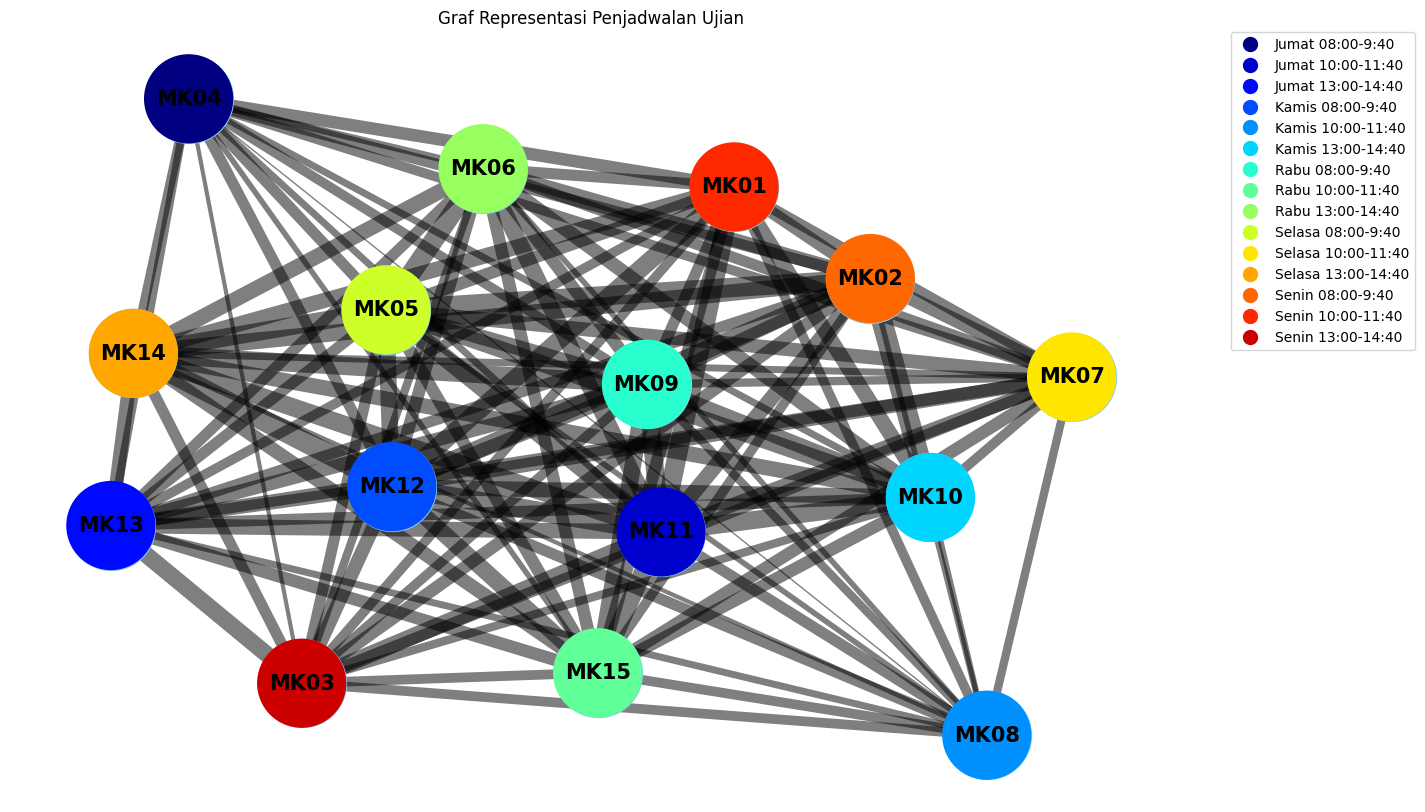

In [242]:

# --- Menjalankan Algoritma dan Visualisasi ---
# Membangun graf
graph = build_graph(data_mahasiswa, data_matkul)

# Menjalankan algoritma greedy untuk penjadwalan
jadwal = greedy_scheduling(graph, data_mahasiswa, sesi)

# Menampilkan hasil penjadwalan
print("Jadwal Ujian:")
sorted_jadwal = sorted(jadwal.items(), key=lambda item: sesi.index(item[1]))
for matkul, slot in sorted_jadwal:
    print(f"{matkul}: {slot}")

# --- Pengujian Algoritma ---
print("\n--- Evaluasi Jadwal ---")
avg_gap = calculate_average_gap(jadwal, data_mahasiswa, sesi)

# Menampilkan hasil
print(f"Rata-rata Jeda Antar Ujian: {avg_gap:.2f} sesi")

# Visualisasi Graf
visualize_graph(graph, jadwal)


